<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[01:56:51] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


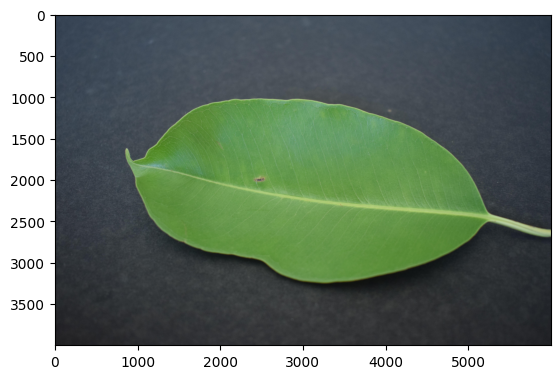

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

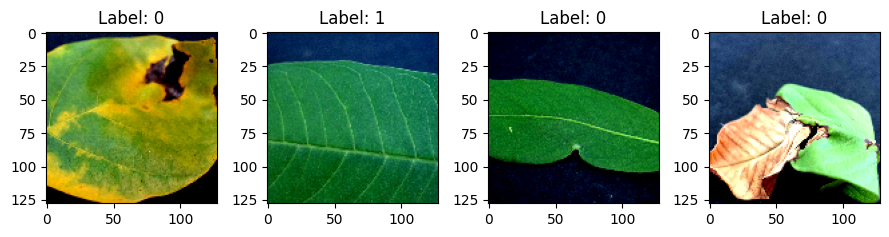

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

01:56:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[01:57:00] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.217683819115931 samples/sec                   batch loss = 0.6735858917236328 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2656090464271201 samples/sec                   batch loss = 0.8982939124107361 | accuracy = 0.4


Epoch[1] Batch[15] Speed: 1.2562159312815229 samples/sec                   batch loss = 0.7588587403297424 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.252267760764031 samples/sec                   batch loss = 0.4954342842102051 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2545751171386574 samples/sec                   batch loss = 0.5244734287261963 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.259396068170606 samples/sec                   batch loss = 1.031864881515503 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.260041996853578 samples/sec                   batch loss = 0.7177473902702332 | accuracy = 0.5214285714285715


Epoch[1] Batch[40] Speed: 1.2649163893265563 samples/sec                   batch loss = 0.2281455248594284 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.2618425296153495 samples/sec                   batch loss = 0.24132265150547028 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.257374699581475 samples/sec                   batch loss = 0.6740269660949707 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.252611826662616 samples/sec                   batch loss = 0.46210193634033203 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2607254401980705 samples/sec                   batch loss = 1.1121103763580322 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.2578258673203848 samples/sec                   batch loss = 0.36141636967658997 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2580098775411348 samples/sec                   batch loss = 0.5868483781814575 | accuracy = 0.5821428571428572


Epoch[1] Batch[75] Speed: 1.2618348423335966 samples/sec                   batch loss = 0.40905338525772095 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2583782483153272 samples/sec                   batch loss = 0.6796800494194031 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.258685640612627 samples/sec                   batch loss = 1.0358772277832031 | accuracy = 0.5823529411764706


Epoch[1] Batch[90] Speed: 1.2638413593294955 samples/sec                   batch loss = 0.22023503482341766 | accuracy = 0.6


Epoch[1] Batch[95] Speed: 1.2665091344955446 samples/sec                   batch loss = 0.6975358128547668 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2631543442252673 samples/sec                   batch loss = 0.8707108497619629 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.2616285544744374 samples/sec                   batch loss = 0.7150247693061829 | accuracy = 0.6166666666666667


Epoch[1] Batch[110] Speed: 1.2614829410633315 samples/sec                   batch loss = 1.9147394895553589 | accuracy = 0.6204545454545455


Epoch[1] Batch[115] Speed: 1.2649282150982095 samples/sec                   batch loss = 0.4657955467700958 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2621433561838247 samples/sec                   batch loss = 0.5238597393035889 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2641694298275192 samples/sec                   batch loss = 0.4234311580657959 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2604718793749126 samples/sec                   batch loss = 0.6855000257492065 | accuracy = 0.6326923076923077


Epoch[1] Batch[135] Speed: 1.2648421971919162 samples/sec                   batch loss = 0.37160712480545044 | accuracy = 0.6388888888888888


Epoch[1] Batch[140] Speed: 1.2625801848880647 samples/sec                   batch loss = 0.822640061378479 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.262944582461308 samples/sec                   batch loss = 0.41148442029953003 | accuracy = 0.6379310344827587


Epoch[1] Batch[150] Speed: 1.2627782298842476 samples/sec                   batch loss = 0.3013228178024292 | accuracy = 0.6416666666666667


Epoch[1] Batch[155] Speed: 1.2593232783928068 samples/sec                   batch loss = 1.0028533935546875 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2565338431802742 samples/sec                   batch loss = 1.1875944137573242 | accuracy = 0.640625


Epoch[1] Batch[165] Speed: 1.2630243521842015 samples/sec                   batch loss = 0.7235549092292786 | accuracy = 0.6348484848484849


Epoch[1] Batch[170] Speed: 1.2647982391207606 samples/sec                   batch loss = 0.6829676032066345 | accuracy = 0.6367647058823529


Epoch[1] Batch[175] Speed: 1.2681053206979456 samples/sec                   batch loss = 1.458935022354126 | accuracy = 0.64


Epoch[1] Batch[180] Speed: 1.2646896443174955 samples/sec                   batch loss = 0.5408955812454224 | accuracy = 0.6416666666666667


Epoch[1] Batch[185] Speed: 1.2546848905861105 samples/sec                   batch loss = 1.1030123233795166 | accuracy = 0.6391891891891892


Epoch[1] Batch[190] Speed: 1.259587914268041 samples/sec                   batch loss = 0.6674180030822754 | accuracy = 0.6381578947368421


Epoch[1] Batch[195] Speed: 1.2614111427852865 samples/sec                   batch loss = 0.5164763927459717 | accuracy = 0.6371794871794871


Epoch[1] Batch[200] Speed: 1.2578497261923496 samples/sec                   batch loss = 0.6432218551635742 | accuracy = 0.64125


Epoch[1] Batch[205] Speed: 1.2617551278964925 samples/sec                   batch loss = 0.3335733413696289 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.2602247628536463 samples/sec                   batch loss = 0.6316834688186646 | accuracy = 0.6440476190476191


Epoch[1] Batch[215] Speed: 1.2587717675915722 samples/sec                   batch loss = 0.7286267280578613 | accuracy = 0.6441860465116279


Epoch[1] Batch[220] Speed: 1.2604416710460133 samples/sec                   batch loss = 0.4729064702987671 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.2629018018983706 samples/sec                   batch loss = 0.3322046399116516 | accuracy = 0.6477777777777778


Epoch[1] Batch[230] Speed: 1.2578666071267643 samples/sec                   batch loss = 0.4892130196094513 | accuracy = 0.65


Epoch[1] Batch[235] Speed: 1.2597029175671446 samples/sec                   batch loss = 0.6078039407730103 | accuracy = 0.6531914893617021


Epoch[1] Batch[240] Speed: 1.2616988593643141 samples/sec                   batch loss = 0.326188862323761 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.2600750252094377 samples/sec                   batch loss = 0.6751788258552551 | accuracy = 0.6591836734693878


Epoch[1] Batch[250] Speed: 1.2628945770227054 samples/sec                   batch loss = 0.4649132192134857 | accuracy = 0.66


Epoch[1] Batch[255] Speed: 1.2591865130904702 samples/sec                   batch loss = 0.27224719524383545 | accuracy = 0.6598039215686274


Epoch[1] Batch[260] Speed: 1.2641960067081324 samples/sec                   batch loss = 1.5420297384262085 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.2664273944563698 samples/sec                   batch loss = 1.529706358909607 | accuracy = 0.6575471698113208


Epoch[1] Batch[270] Speed: 1.2633038633995832 samples/sec                   batch loss = 0.4477691650390625 | accuracy = 0.6592592592592592


Epoch[1] Batch[275] Speed: 1.2639092449962774 samples/sec                   batch loss = 0.33266931772232056 | accuracy = 0.66


Epoch[1] Batch[280] Speed: 1.2586380491804028 samples/sec                   batch loss = 0.7104622721672058 | accuracy = 0.6607142857142857


Epoch[1] Batch[285] Speed: 1.2660328962078438 samples/sec                   batch loss = 0.6546992659568787 | accuracy = 0.6622807017543859


Epoch[1] Batch[290] Speed: 1.2644386795833653 samples/sec                   batch loss = 0.41161105036735535 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2603620378462834 samples/sec                   batch loss = 0.3379448652267456 | accuracy = 0.6593220338983051


Epoch[1] Batch[300] Speed: 1.2646414071296908 samples/sec                   batch loss = 0.4988410770893097 | accuracy = 0.6591666666666667


Epoch[1] Batch[305] Speed: 1.2622480003629377 samples/sec                   batch loss = 0.2974461615085602 | accuracy = 0.660655737704918


Epoch[1] Batch[310] Speed: 1.2678144835794936 samples/sec                   batch loss = 0.9067622423171997 | accuracy = 0.6629032258064517


Epoch[1] Batch[315] Speed: 1.2638370750650196 samples/sec                   batch loss = 0.6962606906890869 | accuracy = 0.6634920634920635


Epoch[1] Batch[320] Speed: 1.2615783685972168 samples/sec                   batch loss = 0.446750670671463 | accuracy = 0.66484375


Epoch[1] Batch[325] Speed: 1.2642987049413346 samples/sec                   batch loss = 0.4387769401073456 | accuracy = 0.6653846153846154


Epoch[1] Batch[330] Speed: 1.263887059957964 samples/sec                   batch loss = 1.038114070892334 | accuracy = 0.6659090909090909


Epoch[1] Batch[335] Speed: 1.2682681902521422 samples/sec                   batch loss = 0.6416564583778381 | accuracy = 0.6664179104477612


Epoch[1] Batch[340] Speed: 1.263073892447447 samples/sec                   batch loss = 0.696865975856781 | accuracy = 0.6669117647058823


Epoch[1] Batch[345] Speed: 1.2668105643860241 samples/sec                   batch loss = 0.23268650472164154 | accuracy = 0.6688405797101449


Epoch[1] Batch[350] Speed: 1.2648509701011386 samples/sec                   batch loss = 0.4636657238006592 | accuracy = 0.67


Epoch[1] Batch[355] Speed: 1.2652124816200785 samples/sec                   batch loss = 0.3166045546531677 | accuracy = 0.6690140845070423


Epoch[1] Batch[360] Speed: 1.2632047506789534 samples/sec                   batch loss = 0.5997477173805237 | accuracy = 0.66875


Epoch[1] Batch[365] Speed: 1.265266487619598 samples/sec                   batch loss = 0.42069604992866516 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2653354807884847 samples/sec                   batch loss = 0.5724571943283081 | accuracy = 0.6702702702702703


Epoch[1] Batch[375] Speed: 1.2647044212674154 samples/sec                   batch loss = 0.4510500729084015 | accuracy = 0.672


Epoch[1] Batch[380] Speed: 1.2715406536106226 samples/sec                   batch loss = 1.3714784383773804 | accuracy = 0.6703947368421053


Epoch[1] Batch[385] Speed: 1.2620299954121583 samples/sec                   batch loss = 0.6534907817840576 | accuracy = 0.6707792207792208


Epoch[1] Batch[390] Speed: 1.2683484421370819 samples/sec                   batch loss = 0.2851663827896118 | accuracy = 0.6717948717948717


Epoch[1] Batch[395] Speed: 1.2641163746660988 samples/sec                   batch loss = 0.733774721622467 | accuracy = 0.670253164556962


Epoch[1] Batch[400] Speed: 1.2637216012789358 samples/sec                   batch loss = 0.5183593034744263 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.2647760228632254 samples/sec                   batch loss = 0.7961498498916626 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.2679272569638367 samples/sec                   batch loss = 1.1904412508010864 | accuracy = 0.6707317073170732


Epoch[1] Batch[415] Speed: 1.2660566852848631 samples/sec                   batch loss = 0.6808487176895142 | accuracy = 0.6704819277108434


Epoch[1] Batch[420] Speed: 1.2652096192399278 samples/sec                   batch loss = 0.4387957453727722 | accuracy = 0.6726190476190477


Epoch[1] Batch[425] Speed: 1.261818329230239 samples/sec                   batch loss = 1.3267109394073486 | accuracy = 0.6723529411764706


Epoch[1] Batch[430] Speed: 1.265341302133095 samples/sec                   batch loss = 0.22103136777877808 | accuracy = 0.672093023255814


Epoch[1] Batch[435] Speed: 1.2693330968764003 samples/sec                   batch loss = 0.17633040249347687 | accuracy = 0.6718390804597701


Epoch[1] Batch[440] Speed: 1.2650934175421114 samples/sec                   batch loss = 0.6582935452461243 | accuracy = 0.6715909090909091


Epoch[1] Batch[445] Speed: 1.2648022438510649 samples/sec                   batch loss = 0.7351402640342712 | accuracy = 0.6713483146067416


Epoch[1] Batch[450] Speed: 1.2678994689657694 samples/sec                   batch loss = 0.5886645913124084 | accuracy = 0.6722222222222223


Epoch[1] Batch[455] Speed: 1.2632218707670715 samples/sec                   batch loss = 0.562326967716217 | accuracy = 0.6736263736263737


Epoch[1] Batch[460] Speed: 1.2616074929962773 samples/sec                   batch loss = 1.0697680711746216 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.2661573927259187 samples/sec                   batch loss = 0.4504196047782898 | accuracy = 0.6731182795698925


Epoch[1] Batch[470] Speed: 1.2621218027775198 samples/sec                   batch loss = 0.6507149338722229 | accuracy = 0.6728723404255319


Epoch[1] Batch[475] Speed: 1.2629904084125807 samples/sec                   batch loss = 0.5363296866416931 | accuracy = 0.6721052631578948


Epoch[1] Batch[480] Speed: 1.2697320572149322 samples/sec                   batch loss = 0.5722419023513794 | accuracy = 0.6729166666666667


Epoch[1] Batch[485] Speed: 1.259825793799427 samples/sec                   batch loss = 0.7371057868003845 | accuracy = 0.6726804123711341


Epoch[1] Batch[490] Speed: 1.2639997070770943 samples/sec                   batch loss = 0.4752271771430969 | accuracy = 0.6719387755102041


Epoch[1] Batch[495] Speed: 1.2618320901196893 samples/sec                   batch loss = 0.23223747313022614 | accuracy = 0.6722222222222223


Epoch[1] Batch[500] Speed: 1.2655902385829796 samples/sec                   batch loss = 0.5230560302734375 | accuracy = 0.674


Epoch[1] Batch[505] Speed: 1.2596863656342583 samples/sec                   batch loss = 0.406080424785614 | accuracy = 0.6747524752475248


Epoch[1] Batch[510] Speed: 1.2606840413446743 samples/sec                   batch loss = 0.518858790397644 | accuracy = 0.6754901960784314


Epoch[1] Batch[515] Speed: 1.2586971613019489 samples/sec                   batch loss = 0.6960127353668213 | accuracy = 0.6766990291262136


Epoch[1] Batch[520] Speed: 1.263347717656226 samples/sec                   batch loss = 0.25588661432266235 | accuracy = 0.6774038461538462


Epoch[1] Batch[525] Speed: 1.2620290460779475 samples/sec                   batch loss = 0.4213707745075226 | accuracy = 0.6776190476190476


Epoch[1] Batch[530] Speed: 1.2632400375902626 samples/sec                   batch loss = 0.4326092600822449 | accuracy = 0.6773584905660377


Epoch[1] Batch[535] Speed: 1.2632567781621804 samples/sec                   batch loss = 0.35706716775894165 | accuracy = 0.6780373831775701


Epoch[1] Batch[540] Speed: 1.2638174630251335 samples/sec                   batch loss = 0.6693456768989563 | accuracy = 0.6791666666666667


Epoch[1] Batch[545] Speed: 1.259078785257148 samples/sec                   batch loss = 1.5915676355361938 | accuracy = 0.6788990825688074


Epoch[1] Batch[550] Speed: 1.2636985661646185 samples/sec                   batch loss = 0.46044331789016724 | accuracy = 0.6804545454545454


Epoch[1] Batch[555] Speed: 1.2576655742600844 samples/sec                   batch loss = 0.5710960030555725 | accuracy = 0.6801801801801802


Epoch[1] Batch[560] Speed: 1.259586779471695 samples/sec                   batch loss = 0.13839317858219147 | accuracy = 0.6803571428571429


Epoch[1] Batch[565] Speed: 1.2606911462177761 samples/sec                   batch loss = 0.5230515599250793 | accuracy = 0.6805309734513274


Epoch[1] Batch[570] Speed: 1.2631015644203996 samples/sec                   batch loss = 0.2196439802646637 | accuracy = 0.6820175438596491


Epoch[1] Batch[575] Speed: 1.2626849015175656 samples/sec                   batch loss = 0.3152848184108734 | accuracy = 0.6826086956521739


Epoch[1] Batch[580] Speed: 1.2596905272221648 samples/sec                   batch loss = 0.34713417291641235 | accuracy = 0.680603448275862


Epoch[1] Batch[585] Speed: 1.264194577815159 samples/sec                   batch loss = 1.0302459001541138 | accuracy = 0.6816239316239316


Epoch[1] Batch[590] Speed: 1.2588572451602864 samples/sec                   batch loss = 0.8762767314910889 | accuracy = 0.6822033898305084


Epoch[1] Batch[595] Speed: 1.2574419865543804 samples/sec                   batch loss = 0.49228760600090027 | accuracy = 0.6827731092436975


Epoch[1] Batch[600] Speed: 1.2616241903266097 samples/sec                   batch loss = 0.37045031785964966 | accuracy = 0.6841666666666667


Epoch[1] Batch[605] Speed: 1.2600104843058353 samples/sec                   batch loss = 0.4660239815711975 | accuracy = 0.6834710743801653


Epoch[1] Batch[610] Speed: 1.2534809667899436 samples/sec                   batch loss = 0.3678503632545471 | accuracy = 0.684016393442623


Epoch[1] Batch[615] Speed: 1.256952671100545 samples/sec                   batch loss = 0.4389304518699646 | accuracy = 0.6841463414634147


Epoch[1] Batch[620] Speed: 1.2593424676083977 samples/sec                   batch loss = 0.32765743136405945 | accuracy = 0.6842741935483871


Epoch[1] Batch[625] Speed: 1.2631545344307384 samples/sec                   batch loss = 0.37177154421806335 | accuracy = 0.6844


Epoch[1] Batch[630] Speed: 1.2565092813626355 samples/sec                   batch loss = 0.7538040280342102 | accuracy = 0.6837301587301587


Epoch[1] Batch[635] Speed: 1.264499004965075 samples/sec                   batch loss = 0.4994611144065857 | accuracy = 0.6846456692913386


Epoch[1] Batch[640] Speed: 1.2550600479066643 samples/sec                   batch loss = 0.30505070090293884 | accuracy = 0.685546875


Epoch[1] Batch[645] Speed: 1.2618246876728905 samples/sec                   batch loss = 0.684575080871582 | accuracy = 0.6856589147286821


Epoch[1] Batch[650] Speed: 1.2528017048099065 samples/sec                   batch loss = 0.7096792459487915 | accuracy = 0.685


Epoch[1] Batch[655] Speed: 1.2539993558546036 samples/sec                   batch loss = 0.4126964807510376 | accuracy = 0.6851145038167938


Epoch[1] Batch[660] Speed: 1.2575443444138525 samples/sec                   batch loss = 0.6386780738830566 | accuracy = 0.6848484848484848


Epoch[1] Batch[665] Speed: 1.2574123002374415 samples/sec                   batch loss = 1.0152369737625122 | accuracy = 0.6842105263157895


Epoch[1] Batch[670] Speed: 1.260737187736357 samples/sec                   batch loss = 1.129343867301941 | accuracy = 0.6832089552238806


Epoch[1] Batch[675] Speed: 1.253720011466193 samples/sec                   batch loss = 0.19109022617340088 | accuracy = 0.6822222222222222


Epoch[1] Batch[680] Speed: 1.2515916800550015 samples/sec                   batch loss = 0.5513604283332825 | accuracy = 0.6816176470588236


Epoch[1] Batch[685] Speed: 1.2555736364213297 samples/sec                   batch loss = 0.3983954191207886 | accuracy = 0.6817518248175183


Epoch[1] Batch[690] Speed: 1.2510926319370448 samples/sec                   batch loss = 0.7198715209960938 | accuracy = 0.6815217391304348


Epoch[1] Batch[695] Speed: 1.253253340888961 samples/sec                   batch loss = 0.48386457562446594 | accuracy = 0.6827338129496403


Epoch[1] Batch[700] Speed: 1.2587784731469551 samples/sec                   batch loss = 0.5156959891319275 | accuracy = 0.6825


Epoch[1] Batch[705] Speed: 1.25766293448108 samples/sec                   batch loss = 0.6890065670013428 | accuracy = 0.6826241134751773


Epoch[1] Batch[710] Speed: 1.2552159209935658 samples/sec                   batch loss = 0.658888041973114 | accuracy = 0.6820422535211268


Epoch[1] Batch[715] Speed: 1.258940278133899 samples/sec                   batch loss = 0.7276878952980042 | accuracy = 0.6821678321678322


Epoch[1] Batch[720] Speed: 1.251724652473126 samples/sec                   batch loss = 0.5389629602432251 | accuracy = 0.6819444444444445


Epoch[1] Batch[725] Speed: 1.2534553067537786 samples/sec                   batch loss = 0.3480612337589264 | accuracy = 0.6824137931034483


Epoch[1] Batch[730] Speed: 1.2617613908091074 samples/sec                   batch loss = 0.377936452627182 | accuracy = 0.6825342465753425


Epoch[1] Batch[735] Speed: 1.2552014588489704 samples/sec                   batch loss = 0.3268744647502899 | accuracy = 0.6833333333333333


Epoch[1] Batch[740] Speed: 1.257635406017532 samples/sec                   batch loss = 0.43385910987854004 | accuracy = 0.683445945945946


Epoch[1] Batch[745] Speed: 1.2549389443449186 samples/sec                   batch loss = 0.3178352117538452 | accuracy = 0.6838926174496645


Epoch[1] Batch[750] Speed: 1.255490295312929 samples/sec                   batch loss = 0.6389017701148987 | accuracy = 0.6846666666666666


Epoch[1] Batch[755] Speed: 1.2546891130254154 samples/sec                   batch loss = 0.3310072720050812 | accuracy = 0.6854304635761589


Epoch[1] Batch[760] Speed: 1.2601673055803655 samples/sec                   batch loss = 0.6890795826911926 | accuracy = 0.6855263157894737


Epoch[1] Batch[765] Speed: 1.2639347635141982 samples/sec                   batch loss = 0.5528118014335632 | accuracy = 0.6859477124183007


Epoch[1] Batch[770] Speed: 1.2573448279815989 samples/sec                   batch loss = 0.501762866973877 | accuracy = 0.6853896103896104


Epoch[1] Batch[775] Speed: 1.2555754217521358 samples/sec                   batch loss = 0.6985025405883789 | accuracy = 0.6851612903225807


Epoch[1] Batch[780] Speed: 1.2506428312334503 samples/sec                   batch loss = 0.4378434419631958 | accuracy = 0.6858974358974359


Epoch[1] Batch[785] Speed: 1.2547712216611544 samples/sec                   batch loss = 0.7262905836105347 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.6865482233502538
[Epoch 1] time cost: 644.0103404521942
[Epoch 1] validation: validation accuracy=0.7544444444444445


Epoch[2] Batch[5] Speed: 1.2617113841345426 samples/sec                   batch loss = 0.7549525499343872 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2544873122097349 samples/sec                   batch loss = 0.5018438696861267 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2520347821933797 samples/sec                   batch loss = 0.15261180698871613 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2594578988245761 samples/sec                   batch loss = 0.3944702744483948 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2598098062356817 samples/sec                   batch loss = 0.48125159740448 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2673493258365516 samples/sec                   batch loss = 0.49969300627708435 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.2640464667655067 samples/sec                   batch loss = 0.7936878204345703 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.257201897415984 samples/sec                   batch loss = 0.4994239807128906 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.2603269115356852 samples/sec                   batch loss = 0.8216754794120789 | accuracy = 0.7


Epoch[2] Batch[50] Speed: 1.2552707674792913 samples/sec                   batch loss = 0.9510053992271423 | accuracy = 0.7


Epoch[2] Batch[55] Speed: 1.2555059855217185 samples/sec                   batch loss = 0.3547792136669159 | accuracy = 0.7045454545454546


Epoch[2] Batch[60] Speed: 1.2539725498875012 samples/sec                   batch loss = 0.3899439871311188 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.2563412327726136 samples/sec                   batch loss = 0.5768402218818665 | accuracy = 0.7115384615384616


Epoch[2] Batch[70] Speed: 1.2608781752741645 samples/sec                   batch loss = 0.36024561524391174 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2565735581889725 samples/sec                   batch loss = 0.6500639915466309 | accuracy = 0.7233333333333334


Epoch[2] Batch[80] Speed: 1.2580098775411348 samples/sec                   batch loss = 0.692675769329071 | accuracy = 0.71875


Epoch[2] Batch[85] Speed: 1.2599489778676294 samples/sec                   batch loss = 0.4950321316719055 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.2598337404317848 samples/sec                   batch loss = 0.47980797290802 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.2560932879647193 samples/sec                   batch loss = 0.43574878573417664 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.2575278491573652 samples/sec                   batch loss = 0.28979504108428955 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2581481800056378 samples/sec                   batch loss = 0.8071722388267517 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2589470799549796 samples/sec                   batch loss = 0.2784702777862549 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2564027638258315 samples/sec                   batch loss = 0.32850974798202515 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2588476106439046 samples/sec                   batch loss = 0.45890796184539795 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2524133112270834 samples/sec                   batch loss = 0.5404859185218811 | accuracy = 0.744


Epoch[2] Batch[130] Speed: 1.25530364010174 samples/sec                   batch loss = 0.4293116629123688 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.258069213687245 samples/sec                   batch loss = 0.4242939352989197 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.257613346406287 samples/sec                   batch loss = 0.7123743891716003 | accuracy = 0.7428571428571429


Epoch[2] Batch[145] Speed: 1.2575877997039306 samples/sec                   batch loss = 0.5462617874145508 | accuracy = 0.743103448275862


Epoch[2] Batch[150] Speed: 1.259932135613423 samples/sec                   batch loss = 0.2399541139602661 | accuracy = 0.7483333333333333


Epoch[2] Batch[155] Speed: 1.2564659946728385 samples/sec                   batch loss = 0.15769608318805695 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.2580237441519933 samples/sec                   batch loss = 0.5245479941368103 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2633291672194962 samples/sec                   batch loss = 0.37754347920417786 | accuracy = 0.7515151515151515


Epoch[2] Batch[170] Speed: 1.2551022988342369 samples/sec                   batch loss = 0.4252931773662567 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2563908146635103 samples/sec                   batch loss = 0.19753557443618774 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2559640869415105 samples/sec                   batch loss = 0.25816774368286133 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.262342498898841 samples/sec                   batch loss = 0.4972204864025116 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2679466134615094 samples/sec                   batch loss = 0.33740079402923584 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.2584408286145223 samples/sec                   batch loss = 0.04797942191362381 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.257480439486641 samples/sec                   batch loss = 0.6616382598876953 | accuracy = 0.74625


Epoch[2] Batch[205] Speed: 1.2578360520245748 samples/sec                   batch loss = 0.39293068647384644 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2575340701746995 samples/sec                   batch loss = 0.6797146797180176 | accuracy = 0.7428571428571429


Epoch[2] Batch[215] Speed: 1.2577284608434072 samples/sec                   batch loss = 0.6334095001220703 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.2584413005861275 samples/sec                   batch loss = 0.839785099029541 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2561823524712301 samples/sec                   batch loss = 0.3120404779911041 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2571506500727214 samples/sec                   batch loss = 0.40063080191612244 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.2548362593271944 samples/sec                   batch loss = 0.4312383234500885 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.2601010516379414 samples/sec                   batch loss = 0.47553861141204834 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.255401610727548 samples/sec                   batch loss = 0.15305250883102417 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2532634516793117 samples/sec                   batch loss = 0.3629148602485657 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.2587105708944577 samples/sec                   batch loss = 0.3944542706012726 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.25426625957303 samples/sec                   batch loss = 0.5835664868354797 | accuracy = 0.7432692307692308


Epoch[2] Batch[265] Speed: 1.2596630045034793 samples/sec                   batch loss = 0.42001938819885254 | accuracy = 0.7415094339622641


Epoch[2] Batch[270] Speed: 1.2556413885866309 samples/sec                   batch loss = 0.30240824818611145 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2629119739029153 samples/sec                   batch loss = 0.4937003254890442 | accuracy = 0.7390909090909091


Epoch[2] Batch[280] Speed: 1.2496060629804668 samples/sec                   batch loss = 0.5531719923019409 | accuracy = 0.7392857142857143


Epoch[2] Batch[285] Speed: 1.2598179418683015 samples/sec                   batch loss = 1.7225431203842163 | accuracy = 0.7403508771929824


Epoch[2] Batch[290] Speed: 1.2594840888676688 samples/sec                   batch loss = 0.2200007140636444 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.2598256991972647 samples/sec                   batch loss = 0.8437265753746033 | accuracy = 0.7406779661016949


Epoch[2] Batch[300] Speed: 1.2569671736276593 samples/sec                   batch loss = 0.327340304851532 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2582578247111995 samples/sec                   batch loss = 0.5016372799873352 | accuracy = 0.7418032786885246


Epoch[2] Batch[310] Speed: 1.2551763856607538 samples/sec                   batch loss = 0.3968053460121155 | accuracy = 0.7451612903225806


Epoch[2] Batch[315] Speed: 1.2591282999720288 samples/sec                   batch loss = 0.6359822154045105 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.25529941352526 samples/sec                   batch loss = 0.41933053731918335 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.2608809233284242 samples/sec                   batch loss = 0.546725332736969 | accuracy = 0.7423076923076923


Epoch[2] Batch[330] Speed: 1.2592319722064353 samples/sec                   batch loss = 0.4064118266105652 | accuracy = 0.7416666666666667


Epoch[2] Batch[335] Speed: 1.256769911441448 samples/sec                   batch loss = 0.2526073157787323 | accuracy = 0.7417910447761195


Epoch[2] Batch[340] Speed: 1.2566895177923356 samples/sec                   batch loss = 0.23909629881381989 | accuracy = 0.7426470588235294


Epoch[2] Batch[345] Speed: 1.2588620624737803 samples/sec                   batch loss = 0.3998275697231293 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.257149237061784 samples/sec                   batch loss = 0.49278733134269714 | accuracy = 0.7435714285714285


Epoch[2] Batch[355] Speed: 1.2582795294573643 samples/sec                   batch loss = 0.45485004782676697 | accuracy = 0.7443661971830986


Epoch[2] Batch[360] Speed: 1.254152715515524 samples/sec                   batch loss = 0.2374734878540039 | accuracy = 0.7444444444444445


Epoch[2] Batch[365] Speed: 1.257169678929427 samples/sec                   batch loss = 0.2514638900756836 | accuracy = 0.7445205479452055


Epoch[2] Batch[370] Speed: 1.2578920708459207 samples/sec                   batch loss = 0.3932521641254425 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.2587791342619183 samples/sec                   batch loss = 0.41232702136039734 | accuracy = 0.742


Epoch[2] Batch[380] Speed: 1.2587959457043287 samples/sec                   batch loss = 0.2153298556804657 | accuracy = 0.7427631578947368


Epoch[2] Batch[385] Speed: 1.2585160653579779 samples/sec                   batch loss = 0.22355233132839203 | accuracy = 0.7428571428571429


Epoch[2] Batch[390] Speed: 1.257697158189758 samples/sec                   batch loss = 0.6913942694664001 | accuracy = 0.7423076923076923


Epoch[2] Batch[395] Speed: 1.260200151189021 samples/sec                   batch loss = 0.21194294095039368 | accuracy = 0.7436708860759493


Epoch[2] Batch[400] Speed: 1.2529121037876112 samples/sec                   batch loss = 0.582580029964447 | accuracy = 0.745


Epoch[2] Batch[405] Speed: 1.2573196690916928 samples/sec                   batch loss = 0.43181464076042175 | accuracy = 0.7444444444444445


Epoch[2] Batch[410] Speed: 1.2575837462635395 samples/sec                   batch loss = 0.22042907774448395 | accuracy = 0.7439024390243902


Epoch[2] Batch[415] Speed: 1.2521520549933745 samples/sec                   batch loss = 0.2704675495624542 | accuracy = 0.7463855421686747


Epoch[2] Batch[420] Speed: 1.2522446739794566 samples/sec                   batch loss = 0.3590560257434845 | accuracy = 0.7476190476190476


Epoch[2] Batch[425] Speed: 1.2593217659671792 samples/sec                   batch loss = 0.6164566874504089 | accuracy = 0.7494117647058823


Epoch[2] Batch[430] Speed: 1.2519636816556363 samples/sec                   batch loss = 0.2922435402870178 | accuracy = 0.7494186046511628


Epoch[2] Batch[435] Speed: 1.2568870372241892 samples/sec                   batch loss = 0.5853227376937866 | accuracy = 0.7517241379310344


Epoch[2] Batch[440] Speed: 1.257884903176274 samples/sec                   batch loss = 0.6815120577812195 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.2544068351544317 samples/sec                   batch loss = 2.5780928134918213 | accuracy = 0.751123595505618


Epoch[2] Batch[450] Speed: 1.2562407638252844 samples/sec                   batch loss = 0.6283458471298218 | accuracy = 0.7505555555555555


Epoch[2] Batch[455] Speed: 1.2560165540206685 samples/sec                   batch loss = 0.3937249779701233 | accuracy = 0.7510989010989011


Epoch[2] Batch[460] Speed: 1.2551289653283035 samples/sec                   batch loss = 0.2200493961572647 | accuracy = 0.7510869565217392


Epoch[2] Batch[465] Speed: 1.2572095283520441 samples/sec                   batch loss = 0.7540868520736694 | accuracy = 0.7516129032258064


Epoch[2] Batch[470] Speed: 1.2578300166244047 samples/sec                   batch loss = 0.43555617332458496 | accuracy = 0.7515957446808511


Epoch[2] Batch[475] Speed: 1.2520602906620133 samples/sec                   batch loss = 1.0043278932571411 | accuracy = 0.7510526315789474


Epoch[2] Batch[480] Speed: 1.2540557833487127 samples/sec                   batch loss = 0.28560200333595276 | accuracy = 0.7510416666666667


Epoch[2] Batch[485] Speed: 1.2568324260239248 samples/sec                   batch loss = 1.0462672710418701 | accuracy = 0.7489690721649485


Epoch[2] Batch[490] Speed: 1.2568375103146323 samples/sec                   batch loss = 0.16550016403198242 | accuracy = 0.7489795918367347


Epoch[2] Batch[495] Speed: 1.257316182733195 samples/sec                   batch loss = 0.6804046630859375 | accuracy = 0.7484848484848485


Epoch[2] Batch[500] Speed: 1.2595545331967963 samples/sec                   batch loss = 1.0331164598464966 | accuracy = 0.749


Epoch[2] Batch[505] Speed: 1.2612743029175455 samples/sec                   batch loss = 0.985504150390625 | accuracy = 0.749009900990099


Epoch[2] Batch[510] Speed: 1.2568574712610956 samples/sec                   batch loss = 0.539385974407196 | accuracy = 0.7490196078431373


Epoch[2] Batch[515] Speed: 1.2603778500591116 samples/sec                   batch loss = 0.8818182945251465 | accuracy = 0.7475728155339806


Epoch[2] Batch[520] Speed: 1.2526848714918817 samples/sec                   batch loss = 0.3355376720428467 | accuracy = 0.7490384615384615


Epoch[2] Batch[525] Speed: 1.25570369696204 samples/sec                   batch loss = 0.45329707860946655 | accuracy = 0.7485714285714286


Epoch[2] Batch[530] Speed: 1.2599628872597441 samples/sec                   batch loss = 0.3863265812397003 | accuracy = 0.7481132075471698


Epoch[2] Batch[535] Speed: 1.2542560388282826 samples/sec                   batch loss = 0.4768379032611847 | accuracy = 0.7481308411214953


Epoch[2] Batch[540] Speed: 1.2570395029149724 samples/sec                   batch loss = 0.4941532611846924 | accuracy = 0.7481481481481481


Epoch[2] Batch[545] Speed: 1.2646089968569478 samples/sec                   batch loss = 0.6502300500869751 | accuracy = 0.7472477064220183


Epoch[2] Batch[550] Speed: 1.259634820972661 samples/sec                   batch loss = 0.734358549118042 | accuracy = 0.7477272727272727


Epoch[2] Batch[555] Speed: 1.263169465738974 samples/sec                   batch loss = 0.31757479906082153 | accuracy = 0.7486486486486487


Epoch[2] Batch[560] Speed: 1.2605208407761859 samples/sec                   batch loss = 0.3366406261920929 | accuracy = 0.7482142857142857


Epoch[2] Batch[565] Speed: 1.2609904762133823 samples/sec                   batch loss = 0.21407616138458252 | accuracy = 0.7504424778761062


Epoch[2] Batch[570] Speed: 1.260785222287468 samples/sec                   batch loss = 0.4330037534236908 | accuracy = 0.7513157894736842


Epoch[2] Batch[575] Speed: 1.2621477239241434 samples/sec                   batch loss = 0.878326952457428 | accuracy = 0.7508695652173913


Epoch[2] Batch[580] Speed: 1.2645530453839584 samples/sec                   batch loss = 0.36087051033973694 | accuracy = 0.7512931034482758


Epoch[2] Batch[585] Speed: 1.2638794429570346 samples/sec                   batch loss = 0.3411369025707245 | accuracy = 0.7508547008547009


Epoch[2] Batch[590] Speed: 1.2626048896053366 samples/sec                   batch loss = 0.4880613088607788 | accuracy = 0.7516949152542373


Epoch[2] Batch[595] Speed: 1.263586067879539 samples/sec                   batch loss = 0.14253920316696167 | accuracy = 0.7516806722689076


Epoch[2] Batch[600] Speed: 1.2655916706326693 samples/sec                   batch loss = 0.6272110939025879 | accuracy = 0.75125


Epoch[2] Batch[605] Speed: 1.2669423894118599 samples/sec                   batch loss = 0.7492455840110779 | accuracy = 0.7516528925619834


Epoch[2] Batch[610] Speed: 1.26356665395861 samples/sec                   batch loss = 0.31361693143844604 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2609142799766353 samples/sec                   batch loss = 0.8916362524032593 | accuracy = 0.751219512195122


Epoch[2] Batch[620] Speed: 1.2607898648739537 samples/sec                   batch loss = 0.7451463937759399 | accuracy = 0.7504032258064516


Epoch[2] Batch[625] Speed: 1.2620911355431719 samples/sec                   batch loss = 0.2578258216381073 | accuracy = 0.7508


Epoch[2] Batch[630] Speed: 1.2604176190546668 samples/sec                   batch loss = 0.1398373544216156 | accuracy = 0.7511904761904762


Epoch[2] Batch[635] Speed: 1.2618472748977532 samples/sec                   batch loss = 0.8914506435394287 | accuracy = 0.7503937007874015


Epoch[2] Batch[640] Speed: 1.2620690142839068 samples/sec                   batch loss = 0.7236940264701843 | accuracy = 0.751171875


Epoch[2] Batch[645] Speed: 1.2593408606073162 samples/sec                   batch loss = 0.12208432704210281 | accuracy = 0.751937984496124


Epoch[2] Batch[650] Speed: 1.2582100769052915 samples/sec                   batch loss = 0.9298136830329895 | accuracy = 0.7519230769230769


Epoch[2] Batch[655] Speed: 1.2600737948957943 samples/sec                   batch loss = 0.8145483136177063 | accuracy = 0.7526717557251908


Epoch[2] Batch[660] Speed: 1.2590356992848797 samples/sec                   batch loss = 0.41121986508369446 | accuracy = 0.7522727272727273


Epoch[2] Batch[665] Speed: 1.260834397542423 samples/sec                   batch loss = 0.77345210313797 | accuracy = 0.7522556390977444


Epoch[2] Batch[670] Speed: 1.265657930342108 samples/sec                   batch loss = 0.3243650794029236 | accuracy = 0.7533582089552239


Epoch[2] Batch[675] Speed: 1.2622960551367308 samples/sec                   batch loss = 0.7287093997001648 | accuracy = 0.7533333333333333


Epoch[2] Batch[680] Speed: 1.2644450644619767 samples/sec                   batch loss = 1.2532939910888672 | accuracy = 0.7525735294117647


Epoch[2] Batch[685] Speed: 1.2600969819800265 samples/sec                   batch loss = 0.13647188246250153 | accuracy = 0.754014598540146


Epoch[2] Batch[690] Speed: 1.2594127070155974 samples/sec                   batch loss = 0.7961306571960449 | accuracy = 0.7539855072463768


Epoch[2] Batch[695] Speed: 1.2626984912463841 samples/sec                   batch loss = 0.6753146052360535 | accuracy = 0.7532374100719424


Epoch[2] Batch[700] Speed: 1.2585872511861602 samples/sec                   batch loss = 0.4089619517326355 | accuracy = 0.7528571428571429


Epoch[2] Batch[705] Speed: 1.2612674759263172 samples/sec                   batch loss = 0.11906025558710098 | accuracy = 0.7535460992907801


Epoch[2] Batch[710] Speed: 1.2661687639274317 samples/sec                   batch loss = 0.2654539942741394 | accuracy = 0.7531690140845071


Epoch[2] Batch[715] Speed: 1.263207223551897 samples/sec                   batch loss = 0.7863555550575256 | accuracy = 0.7513986013986014


Epoch[2] Batch[720] Speed: 1.2609363607742232 samples/sec                   batch loss = 0.20007769763469696 | accuracy = 0.7527777777777778


Epoch[2] Batch[725] Speed: 1.2568599193453476 samples/sec                   batch loss = 0.6439396142959595 | accuracy = 0.7531034482758621


Epoch[2] Batch[730] Speed: 1.258898996435479 samples/sec                   batch loss = 0.3572985529899597 | accuracy = 0.7523972602739726


Epoch[2] Batch[735] Speed: 1.2578461425885985 samples/sec                   batch loss = 0.5308008790016174 | accuracy = 0.753061224489796


Epoch[2] Batch[740] Speed: 1.259931378668751 samples/sec                   batch loss = 0.3820754587650299 | accuracy = 0.7533783783783784


Epoch[2] Batch[745] Speed: 1.2619374420450449 samples/sec                   batch loss = 0.6325419545173645 | accuracy = 0.7526845637583892


Epoch[2] Batch[750] Speed: 1.2643521565416174 samples/sec                   batch loss = 0.5081655979156494 | accuracy = 0.7526666666666667


Epoch[2] Batch[755] Speed: 1.2619741769874746 samples/sec                   batch loss = 0.1839897632598877 | accuracy = 0.7533112582781457


Epoch[2] Batch[760] Speed: 1.2589177948594463 samples/sec                   batch loss = 0.018949266523122787 | accuracy = 0.7546052631578948


Epoch[2] Batch[765] Speed: 1.2623622551547613 samples/sec                   batch loss = 0.4704032838344574 | accuracy = 0.75359477124183


Epoch[2] Batch[770] Speed: 1.2652242175141066 samples/sec                   batch loss = 0.9202344417572021 | accuracy = 0.7532467532467533


Epoch[2] Batch[775] Speed: 1.2643455820368625 samples/sec                   batch loss = 0.5954619646072388 | accuracy = 0.7541935483870967


Epoch[2] Batch[780] Speed: 1.2581963005440315 samples/sec                   batch loss = 0.15097551047801971 | accuracy = 0.7548076923076923


Epoch[2] Batch[785] Speed: 1.2626115410405556 samples/sec                   batch loss = 1.119104266166687 | accuracy = 0.7550955414012739


[Epoch 2] training: accuracy=0.7550761421319797
[Epoch 2] time cost: 643.7023549079895
[Epoch 2] validation: validation accuracy=0.7788888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

[02:19:40] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)